In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from datetime import datetime, timedelta
from matplotlib import ticker
import math

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

# useful functions 

def rounditup(x, precision, method):
    if method == "floor":
        return math.floor(x / precision) * precision
    elif method == "ceiling":
        return math.ceil(x / precision) * precision
    else:
        return "give the parameter floor or ceiling"

# plotting functions
def contour_levels_func(min_contour_level, max_contour_level, levels, variable):
    """Function to define contour levels for contourf"""
    import numpy as np
    
    # Adjust the conditional check
    if variable == 'PSAL' or variable == 'density':
        distance_levels = abs(max_contour_level - min_contour_level) / levels / 100
    else:
        distance_levels = abs(max_contour_level - min_contour_level) / levels  # For other variables

    # Generate contour levels using linspace for guaranteed levels
    contour_levels = np.linspace(min_contour_level, max_contour_level, levels + 1)  # +1 to include max level
    return contour_levels

def gridding_func(pos_min_max, depth_min_max, pos_array, depth, param):
    import numpy as np
    from scipy.interpolate import griddata
    grid_method = "linear"  # choose the gridding method here
    # method to do the regridding, can be nearest (for nearest neighbour) or linear

    xi = np.linspace(min(pos_min_max), max(pos_min_max), 1000)
    yi = np.linspace(min(depth_min_max), max(depth_min_max), 200)
    zi = griddata((pos_array, depth), param, (xi[None, :], yi[:, None]), method=grid_method)
    return xi, yi, zi

def nonlinear_colormap():
    import pylab as pyl
    #import numpy as np
    levels1 = [0, 1, 2]

def create_contour_plot(df, variable, save_path, log_transf = True, divergent_color = False, cb_label="MaP concentration (part$\cdot$L$^{-1}$)", display_features = False, show_xticks = True):
    
    # Define the base date
    ref_date = datetime(2021, 4, 13)

    # Calculate the number of days between each date and the base date
    df['days'] = (df['date'] - ref_date).dt.days

    # Keep only 0-600m
    df = df[df['Depth [m]'] < 1000]

    # For log transformation
    if log_transf:
        df[f'{variable}_log'] = df[variable].apply(lambda x: np.log1p(x))

    # Prepare data for contour plotting
    df.days = df.days.astype(float)
    dat = np.array(df['days'])
    depth = np.array(df['Depth [m]'] * (-1))

    # Prepare for contour levels
    if log_transf:
        parameter_dict = {f'{variable}': [min(df[f'{variable}_log']), max(df[f'{variable}_log'])]}
    else:
        parameter_dict = {f'{variable}': [min(df[variable]), max(df[variable])]}
    
    legend_dict = {f'{variable}': cb_label}

    # Create the figure and the subplots
    fig, ax = plt.subplots(figsize=(30, 15))

    # Generate contour plots for each parameter
    for p in parameter_dict.keys():
        #ax1 = plt.subplot(2, 1, 2)
        param = np.array(df[p])  # Select the concentration

        # Set limits for depth and time
        depth_min_max = [0, -600]  # Adjusted to 600m for contour plot
        pos_min_max = [min(df.days), max(df.days)]  # Date transect

        # Interpolate
        xi, yi, zi = gridding_func(pos_min_max, depth_min_max, dat, depth, param)
                
        # Set contour levels
        levels = 15
        min_contour_level = parameter_dict[p][0]
        max_contour_level = parameter_dict[p][1]
        contour_levels = contour_levels_func(min_contour_level, max_contour_level, levels)
        
        if divergent_color: 
            cmap = "bwr"
            max_abs_value = max(abs(min_contour_level), abs(max_contour_level))
            min_contour_level = -max_abs_value
            max_contour_level = max_abs_value
            contour_levels = contour_levels_func(min_contour_level, max_contour_level, levels)
            norm = mcolors.TwoSlopeNorm(vmin=min_contour_level, vcenter=0, vmax=max_contour_level)
        else:
            cmap = 'viridis'
        
        # Interpolate MLD
        mld_raw = df[['days', 'MLD']]
        mld_raw.days = mld_raw.days.astype(float)
        mld_interp = np.interp(xi, mld_raw.days, mld_raw.MLD)

        # Convert days back to dates for plotting
        date_list = [ref_date + timedelta(days=i) for i in xi]
        formatted_dates = [d.strftime("%Y-%m-%d") for d in date_list]

        # Plot contour
        if log_transf and not divergent_color:
            p1 = ax.contourf(formatted_dates, yi, np.log1p(zi), contour_levels, cmap=cmap, alpha=1, extend="both")
        elif log_transf and divergent_color:
            p1 = ax.contourf(formatted_dates, yi, np.log1p(zi), contour_levels, cmap=cmap, norm = norm, alpha=1, extend="both")
        elif not log_transf and not divergent_color:
            p1 = ax.contourf(formatted_dates, yi, zi, contour_levels, cmap=cmap, alpha=1, extend="both")
        elif not log_transf and divergent_color:
            p1 = ax.contourf(formatted_dates, yi, zi, contour_levels, cmap=cmap, norm = norm, alpha=1, extend="both")
        
        # mld
        ax.plot(formatted_dates, -mld_interp, color='red')

        if display_features:
            # Represent features with dashed lines
            feature_dates = ["2021-10-01", "2021-10-17", "2021-12-01", 
                             "2021-12-19", "2022-01-25", "2022-04-25"]
            for date in feature_dates:
                ax.axvline(x=date, color='black', linestyle='dashed')

        # Plotting parameters for contour
        ax.set_ylabel("Pressure [dbar]", fontsize=25)
        ax.set_ylim(-600, 0)
        ax.tick_params(axis='y', labelsize=25)

        # Set y-ticks to absolute values
        y_ticks = ax.get_yticks()  # Get current y-ticks
        ax.set_yticklabels([abs(int(y)) for y in y_ticks])

        # Set x-axis tick frequency
        if show_xticks:
            ax.set_xticks(formatted_dates[::60])  # Show ticks
            ax.set_xticklabels(formatted_dates[::60], rotation=45, fontsize=25)
        else:
            ax.set_xticks([])  # Hide x-tick labels

        # Colorbar for the contour plot
        cb = plt.colorbar(p1, orientation='vertical')
        cb.ax.set_ylabel(legend_dict[p], fontsize=20)
        cb.ax.tick_params(labelsize=20)
    
        tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator
        
    '''
    # Scatter plot for FTLE values on the first subplot
    ax2 = plt.subplot(2, 1, 1)
    pos_min_max_b = df['date']  # Date transect
    formatted_dates_b = [d.strftime("%Y-%m-%d") for d in pos_min_max_b]
    p2 = ax2.scatter(formatted_dates_b, [1] * len(formatted_dates_b), c=df['FTLE'], cmap='Blues')
    ax2.set_xticks(formatted_dates[::10])
    
    ax2.set_xlim(min(formatted_dates_b), max(formatted_dates_b))
    ax2.set_ylim(0, 15)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_ylabel('')
    plt.axis('off')

    # Colorbar for FTLE scatter plot (horizontal at the top)
    cb2 = plt.colorbar(p2, orientation='vertical')
    cb2.ax.set_ylabel('FTLE [days$^{-1}$]', fontsize=25)
    tick_locator2 = ticker.MaxNLocator(nbins=5)
    cb2.locator = tick_locator2
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Show the plot
    '''
    plt.savefig(save_path, dpi = 300)


In [44]:
profile_date = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/profile_metadata.csv')
profile_date

,Profile,Date_Time,CYCLE_NUMBER,Longitude,Latitude
0,0000a_WMO6903095,2021-04-13 14:01:29,1,13.894444,-33.070000
1,0002a_WMO6903095,2021-04-14 01:50:56,3,14.000833,-33.040556
2,0001a_WMO6903095,2021-04-13 20:03:06,2,13.943056,-33.051944
3,0003a_WMO6903095,2021-04-14 07:32:27,4,14.058889,-33.047778
4,0004a_WMO6903095,2021-04-14 13:18:31,5,14.103056,-33.064722
...,...,...,...,...,...
179,0179a_WMO6903095,2022-09-13 19:52:18,180,11.428056,-34.176389
180,0180a_WMO6903095,2022-09-14 19:52:18,181,11.068056,-34.191667
181,0181a_WMO6903095,2022-09-15 19:52:18,182,10.725556,-34.246944
182,0182a_WMO6903095,2022-09-16 19:52:18,183,10.433333,-34.339444


In [45]:
# Load the MiP_MaP dataset
MiP_MaP = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/Mip_Map_ano.csv')
MiP_MaP = MiP_MaP.drop(['Profile', 'Date_Time'], axis=1)
MiP_MaP = pd.merge(MiP_MaP, profile_date, on='CYCLE_NUMBER')
MiP_MaP['Date_Time'] = pd.to_datetime(MiP_MaP['Date_Time']).dt.strftime('%Y-%m-%d %H:%M:%S')

# Load the mld data
mld = pd.read_csv("/home/aaccardo/Accardo_et_al/Data/station_clines.csv")

MiP_MaP = MiP_MaP.dropna(subset=['Pressure [dbar]'])
MiP_MaP['Pressure [dbar]'] = MiP_MaP["Pressure [dbar]"].apply(lambda x: rounditup(x, 10, "floor"))
MiP_MaP = MiP_MaP.groupby(['CYCLE_NUMBER', 'Pressure [dbar]', 'Date_Time']).mean(numeric_only=True).reset_index()
MiP_MaP = pd.merge(MiP_MaP, mld, on='CYCLE_NUMBER')

MiP_MaP = MiP_MaP.rename(columns={'Date_Time': 'date', 'Longitude': 'lon', 'Latitude': 'lat', 'Pressure [dbar]': 'Depth [m]'})

# Convert the date column to datetime objects
MiP_MaP['date'] = pd.to_datetime(MiP_MaP['date'])
MiP_MaP

# add the FTLE values 
lagrangian = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/lagrangian/final_data_an35be.csv')
front = lagrangian[['Profile', 'Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010']]
front = pd.merge(profile_date, front, on = 'Profile')
front = front[['CYCLE_NUMBER', 'Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010']]
front.rename(columns={'Ftle_GlobEkmanDt_005daysBackward_mean_delta0ftle010': 'FTLE'}, inplace=True)
MiP_MaP = pd.merge(MiP_MaP, front, on = 'CYCLE_NUMBER')
MiP_MaP

,CYCLE_NUMBER,Depth [m],date,MaP_abun,Map_POC_cont_mgC_m3,MiP_abun,Mip_POC_cont_mgC_m3,MaP_abun_roll,Map_POC_cont_mgC_m3_roll,MiP_abun_roll,Mip_POC_cont_mgC_m3_roll,MaP_abun_diff,Map_POC_cont_mgC_m3_diff,MiP_abun_diff,Mip_POC_cont_mgC_m3_diff,lon,lat,thermocline,pycnocline,strat_index,DCM,MLD,temp_mld,chla_dcm_stock,FTLE
0,1,0,2021-04-13 14:01:29,0.238527,0.094523,62.902333,2.072367,0.114231,0.046661,68.513611,2.247439,0.124296,0.047862,-5.611278,-0.175072,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
1,1,10,2021-04-13 14:01:29,0.127756,0.060947,43.213750,1.355725,0.201421,0.085294,55.297074,1.799267,-0.073665,-0.024348,-12.083324,-0.443542,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
2,1,20,2021-04-13 14:01:29,0.050000,0.015932,35.858750,1.071492,0.152297,0.063101,48.236020,1.535285,-0.102297,-0.047169,-12.377270,-0.463792,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
3,1,30,2021-04-13 14:01:29,0.024510,0.010241,26.844750,0.738827,0.108041,0.044771,42.452106,1.318580,-0.083531,-0.034529,-15.607356,-0.579753,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
4,1,40,2021-04-13 14:01:29,0.068744,0.024106,26.840500,0.786525,0.100421,0.040757,38.971082,1.197721,-0.031677,-0.016650,-12.130582,-0.411196,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15425,184,910,2022-09-17 19:52:17,0.083335,0.026555,20.250000,0.499975,0.004167,0.001328,22.384625,0.553433,0.079168,0.025227,-2.134625,-0.053458,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650,0.113739
15426,184,920,2022-09-17 19:52:17,0.000000,0.000000,21.028000,0.552730,0.008334,0.002655,22.116250,0.551341,-0.008334,-0.002655,-1.088250,0.001389,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650,0.113739
15427,184,930,2022-09-17 19:52:17,0.000000,0.000000,22.778000,0.548275,0.008334,0.002655,21.900350,0.546487,-0.008334,-0.002655,0.877650,0.001788,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650,0.113739
15428,184,940,2022-09-17 19:52:17,0.000000,0.000000,23.541500,0.581895,0.008334,0.002655,22.089050,0.551605,-0.008334,-0.002655,1.452450,0.030290,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650,0.113739


/tmp/ipykernel_428830/334987462.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks])


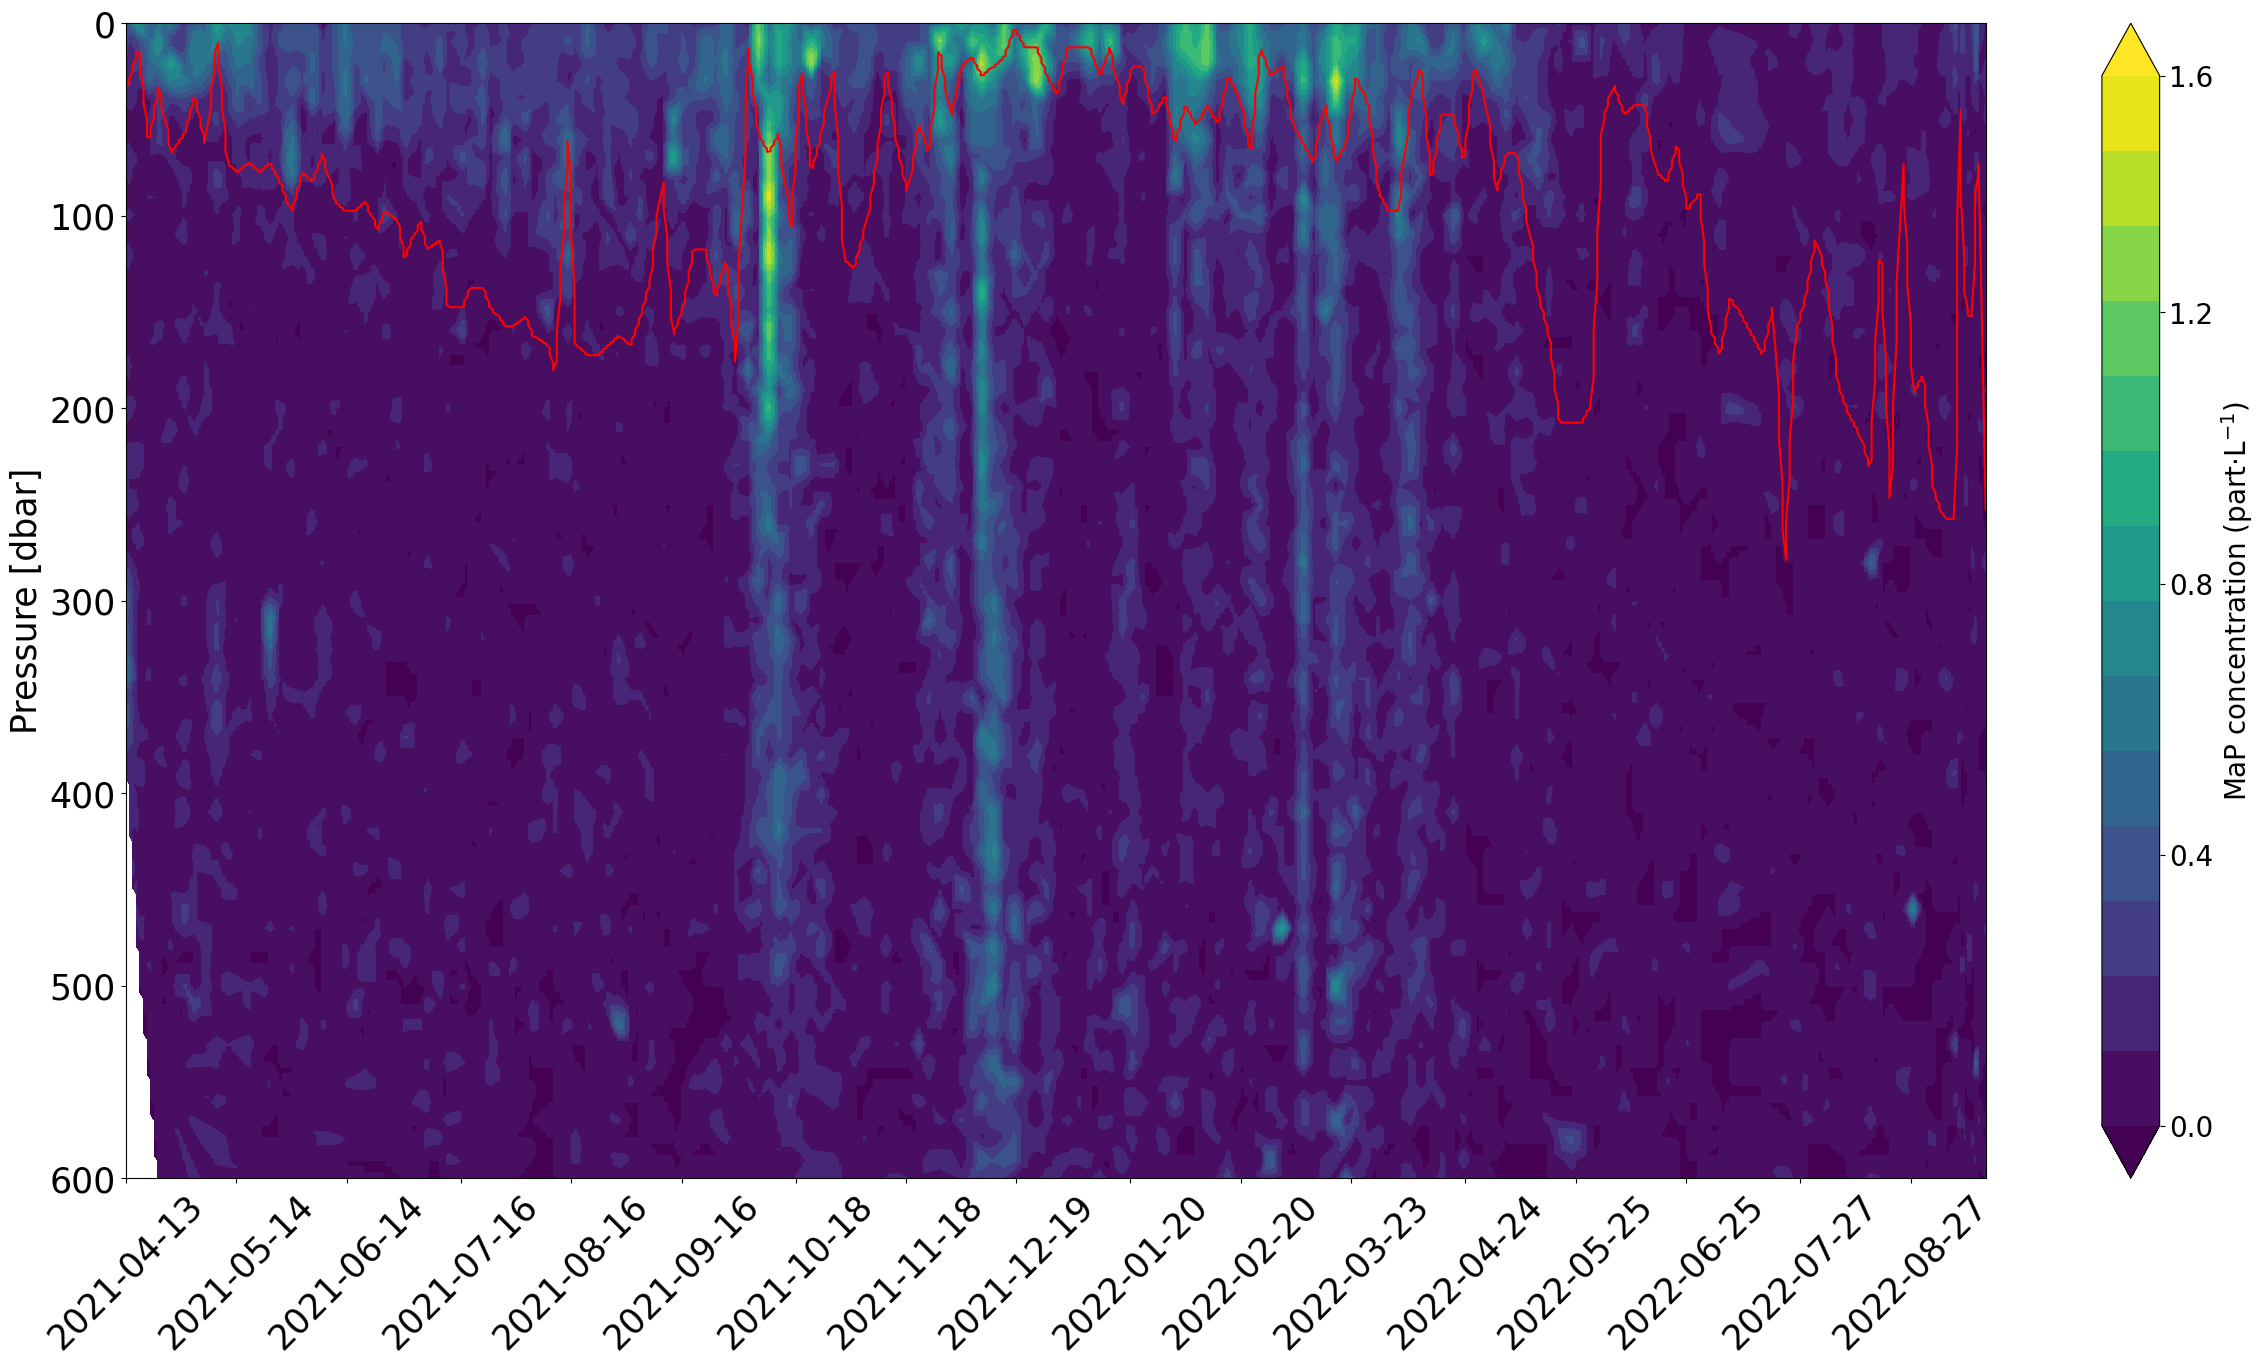

In [8]:
create_contour_plot(
    df=MiP_MaP, 
    variable='MaP_abun',
    save_path = '/home/aaccardo/Accardo_et_al/Figures/contour_plots/test.png',
    log_transf=True, 
    divergent_color=False, 
    cb_label="MaP concentration (part$\cdot$L$^{-1}$)", 
    display_features=False, 
    show_xticks=True
)


In [67]:
MiP_MaP

,CYCLE_NUMBER,Depth [m],date,MaP_abun,Map_POC_cont_mgC_m3,MiP_abun,Mip_POC_cont_mgC_m3,MaP_abun_roll,Map_POC_cont_mgC_m3_roll,MiP_abun_roll,Mip_POC_cont_mgC_m3_roll,MaP_abun_diff,Map_POC_cont_mgC_m3_diff,MiP_abun_diff,Mip_POC_cont_mgC_m3_diff,lon,lat,thermocline,pycnocline,strat_index,DCM,MLD,temp_mld,chla_dcm_stock,FTLE
0,1,0,2021-04-13 14:01:29,0.238527,0.094523,62.902333,2.072367,0.114231,0.046661,68.513611,2.247439,0.124296,0.047862,-5.611278,-0.175072,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
1,1,10,2021-04-13 14:01:29,0.127756,0.060947,43.213750,1.355725,0.201421,0.085294,55.297074,1.799267,-0.073665,-0.024348,-12.083324,-0.443542,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
2,1,20,2021-04-13 14:01:29,0.050000,0.015932,35.858750,1.071492,0.152297,0.063101,48.236020,1.535285,-0.102297,-0.047169,-12.377270,-0.463792,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
3,1,30,2021-04-13 14:01:29,0.024510,0.010241,26.844750,0.738827,0.108041,0.044771,42.452106,1.318580,-0.083531,-0.034529,-15.607356,-0.579753,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
4,1,40,2021-04-13 14:01:29,0.068744,0.024106,26.840500,0.786525,0.100421,0.040757,38.971082,1.197721,-0.031677,-0.016650,-12.130582,-0.411196,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763,0.107897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15425,184,910,2022-09-17 19:52:17,0.083335,0.026555,20.250000,0.499975,0.004167,0.001328,22.384625,0.553433,0.079168,0.025227,-2.134625,-0.053458,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650,0.113739
15426,184,920,2022-09-17 19:52:17,0.000000,0.000000,21.028000,0.552730,0.008334,0.002655,22.116250,0.551341,-0.008334,-0.002655,-1.088250,0.001389,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650,0.113739
15427,184,930,2022-09-17 19:52:17,0.000000,0.000000,22.778000,0.548275,0.008334,0.002655,21.900350,0.546487,-0.008334,-0.002655,0.877650,0.001788,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650,0.113739
15428,184,940,2022-09-17 19:52:17,0.000000,0.000000,23.541500,0.581895,0.008334,0.002655,22.089050,0.551605,-0.008334,-0.002655,1.452450,0.030290,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650,0.113739


In [87]:
def create_contour_plot(ax, df, variable, level, log_transf = True, divergent_color = False, cb_label="MaP concentration (part$\cdot$L$^{-1}$)", display_features = False, show_xticks = True, show_yticks = True):
    
    # Define the base date
    ref_date = datetime(2021, 4, 13)
    df['date'] = pd.to_datetime(df['date'])
    # Calculate the number of days between each date and the base date
    df['days'] = (df['date'] - ref_date).dt.days

    # Keep only 0-600m
    df = df[df['Depth [m]'] < 1000]

    # For log transformation
    if log_transf:
        df[f'{variable}_log'] = df[variable].apply(lambda x: np.log1p(x))

    # Prepare data for contour plotting
    df.days = df.days.astype(float)
    dat = np.array(df['days'])
    real_date = np.unique([ref_date + timedelta(hours=j) for j in dat])
    real_formatted_dates = [k.strftime("%d/%m/%y") for k in real_date]
    depth = np.array(df['Depth [m]'] * (-1))

    # Prepare for contour levels
    if log_transf:
        parameter_dict = {f'{variable}': [min(df[f'{variable}_log']), max(df[f'{variable}_log'])]}
    else:
        parameter_dict = {f'{variable}': [min(df[variable]), max(df[variable])]}
    
    legend_dict = {f'{variable}': cb_label}

    # Generate contour plots for each parameter
    for p in parameter_dict.keys():
        #ax1 = plt.subplot(2, 1, 2)
        param = np.array(df[p])  # Select the concentration

        # Set limits for depth and time
        depth_min_max = [0, -1000]  # Adjusted to 600m for contour plot
        pos_min_max = [min(df.days), max(df.days)]  # Date transect

        # Interpolate
        xi, yi, zi = gridding_func(pos_min_max, depth_min_max, dat, depth, param)
                
        # Set contour levels
        levels = level
        min_contour_level = parameter_dict[p][0]
        max_contour_level = parameter_dict[p][1]
        contour_levels = contour_levels_func(min_contour_level, max_contour_level, levels, variable = variable)
        
        if divergent_color: 
            cmap = "bwr"
            max_abs_value = max(abs(min_contour_level), abs(max_contour_level))
            min_contour_level = -max_abs_value
            max_contour_level = max_abs_value
            contour_levels = contour_levels_func(min_contour_level, max_contour_level, levels)
            norm = mcolors.TwoSlopeNorm(vmin=min_contour_level, vcenter=0, vmax=max_contour_level)
        else:
            cmap = 'viridis'
        
        # Interpolate MLD
        mld_raw = df[['days', 'MLD']]
        mld_raw.days = mld_raw.days.astype(float)
        mld_interp = np.interp(xi, mld_raw.days, mld_raw.MLD)

        # Convert days back to dates for plotting
        #date_list = [ref_date + timedelta(days=i) for i in xi]
        #formatted_dates = [d.strftime("%Y-%m-%d") for d in date_list]
        date_list = [ref_date + timedelta(days=i) for i in xi]
        formatted_dates = [d.strftime("%d/%m/%y") for d in date_list]
        
        # Plot contour
        if log_transf:
            p1 = ax.contourf(formatted_dates, yi, np.log1p(zi), contour_levels, cmap=cmap, alpha=1, extend="both")
        else:
            p1 = ax.contourf(formatted_dates, yi, zi, contour_levels, cmap=cmap, alpha=1, extend="both")

        # Plot real data (used for interpolation)    
        for date in real_formatted_dates:  
            ax.axvline(date, color='white', linestyle='-', linewidth=1.5, alpha = 0.3) # Real profiles 
            dataframe = df[df['date'] == date]
            dataframe = dataframe[['Depth [m]', 'date']]
            dataframe['date'] = dataframe['date'].dt.strftime("%d/%m/%y")
            #print(dataframe)
            ax.scatter(dataframe['date'], dataframe['Depth [m]']* (-1), color = 'white', s = 1, alpha = 0.3) # Real sampled depths
        
        # mld
        ax.plot(formatted_dates, -mld_interp, color='red')

        if display_features:
            # Represent features with dashed lines
            feature_dates = ["01-10-21", "17-10-21", "01-12-21", 
                             "19-12-21", "25-01-22", "25-04-22"]
            for date in feature_dates:
                ax.axvline(x=date, color='black', linestyle='dashed')

        # Plotting parameters for contour
        if variable == 'CHLA_ADJUSTED':
            ax.set_ylim(-200, 0)
        else:
            ax.set_ylim(-1000, 0)
        ax.tick_params(axis='y', labelsize=25)

        if show_yticks:
            # Set y-ticks to absolute values
            ax.set_ylabel("Pressure (dbar)", fontsize=35)
            y_ticks = ax.get_yticks()  # Get current y-ticks
            ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize = 35)
            ax.tick_params(axis='y', length=5, width=3)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis='y', length=5, width=3)
            ax.set_yticks([])  # Hide y-tick labels
        
        # Set x-axis tick frequency
        if show_xticks:
            ax.set_xticks(formatted_dates[::120])  # Show ticks
            ax.set_xticklabels(formatted_dates[::120], rotation=45, fontsize=35)
            ax.tick_params(axis='x', length=5, width=3)
        else:
            ax.set_xticks([])  # Hide x-tick labels
            ax.tick_params(axis='x', length=5, width=3)

        # Colorbar for the contour plot
        cb = plt.colorbar(p1, orientation='vertical')
        cb.ax.set_ylabel(legend_dict[p], fontsize=35)
        cb.ax.tick_params(labelsize=35)
    
        tick_locator = ticker.MaxNLocator(nbins=4)
        cb.locator = tick_locator
        
    '''
    # Scatter plot for FTLE values on the first subplot
    ax2 = plt.subplot(2, 1, 1)
    pos_min_max_b = df['date']  # Date transect
    formatted_dates_b = [d.strftime("%Y-%m-%d") for d in pos_min_max_b]
    p2 = ax2.scatter(formatted_dates_b, [1] * len(formatted_dates_b), c=df['FTLE'], cmap='Blues')
    ax2.set_xticks(formatted_dates[::10])
    
    ax2.set_xlim(min(formatted_dates_b), max(formatted_dates_b))
    ax2.set_ylim(0, 15)
    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_ylabel('')
    plt.axis('off')

    # Colorbar for FTLE scatter plot (horizontal at the top)
    cb2 = plt.colorbar(p2, orientation='vertical')
    cb2.ax.set_ylabel('FTLE [days$^{-1}$]', fontsize=25)
    tick_locator2 = ticker.MaxNLocator(nbins=5)
    cb2.locator = tick_locator2
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Show the plot
    '''


/tmp/ipykernel_428830/1894706962.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize = 35)


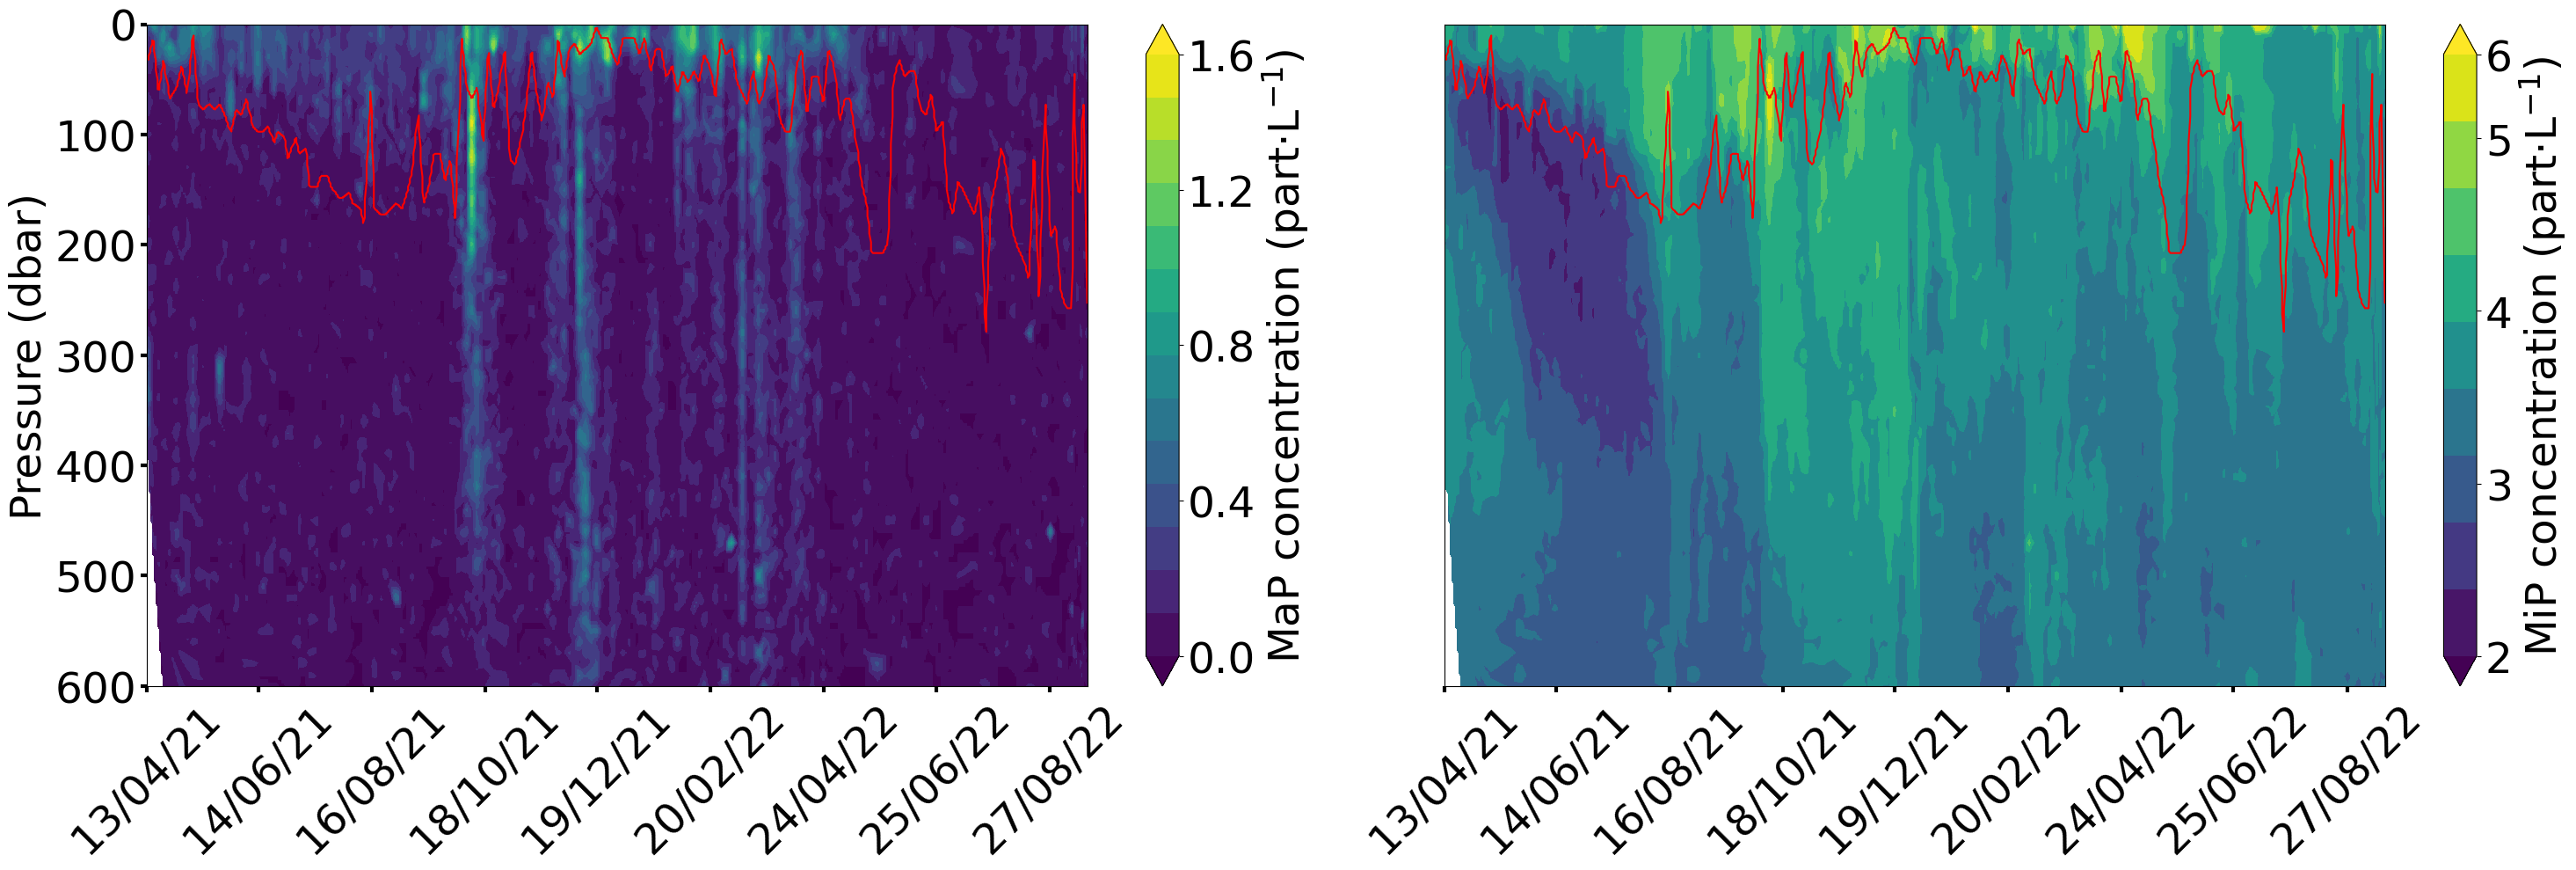

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

create_contour_plot(
    ax = axs[0],
    df=MiP_MaP, 
    variable='MaP_abun',
    log_transf=True, 
    divergent_color=False, 
    cb_label="MaP concentration (part$\cdot$L$^{-1}$)", 
    display_features=False, 
    show_xticks=True, 
    show_yticks=True
)

create_contour_plot(
    ax = axs[1],
    df=MiP_MaP, 
    variable='MiP_abun',
    log_transf=True, 
    divergent_color=False, 
    cb_label="MiP concentration (part$\cdot$L$^{-1}$)", 
    display_features=False, 
    show_xticks=True,
    show_yticks=False
)

# Show the figure
plt.tight_layout()

fig.savefig(f'/home/aaccardo/Accardo_et_al/Figures/contour_plots/MaP_MiP_abun.png', dpi = 300)
plt.show()

In [116]:
# import AOU anomalies
AOU = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/AOU.csv')
AOU = pd.merge(AOU, profile_date, on='CYCLE_NUMBER')
AOU['Date_Time'] = pd.to_datetime(AOU['Date_Time']).dt.strftime('%Y-%m-%d %H:%M:%S')

mld = pd.read_csv("/home/aaccardo/Accardo_et_al/Data/station_clines.csv")

AOU['Depth [m]'] = AOU["Depth [m]"].apply(lambda x: rounditup(x, 20, "floor"))
AOU = AOU.groupby(['CYCLE_NUMBER', 'Depth [m]', 'Date_Time']).mean(numeric_only=True).reset_index()
AOU = pd.merge(AOU, mld, on = 'CYCLE_NUMBER')
AOU = AOU.rename(columns={'Date_Time': 'date', 'Longitude' : 'lon', 'Latitude':'lat'})
AOU['date'] = pd.to_datetime(AOU['date'])
AOU

,CYCLE_NUMBER,Depth [m],date,AOU µmol/kg,lon,lat,thermocline,pycnocline,strat_index,DCM,MLD,temp_mld,chla_dcm_stock
0,1,0,2021-04-13 14:01:29,-8.781644,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
1,1,20,2021-04-13 14:01:29,-7.169349,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
2,1,40,2021-04-13 14:01:29,-2.235545,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
3,1,60,2021-04-13 14:01:29,21.013241,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
4,1,80,2021-04-13 14:01:29,86.243441,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8100,184,900,2022-09-17 19:52:17,80.788295,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650
8101,184,920,2022-09-17 19:52:17,82.156746,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650
8102,184,940,2022-09-17 19:52:17,81.356837,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650
8103,184,960,2022-09-17 19:52:17,80.539987,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650


In [117]:
# import temp, sal, dens, bbsr data 
ctd = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/bgc_benguela_clean.csv', delimiter = ';')
ctd = ctd[['CYCLE_NUMBER', 'binned_depth', 'TEMP', 'PSAL', 'CHLA_ADJUSTED', 'dens']]
ctd = pd.merge(ctd, profile_date, on = 'CYCLE_NUMBER')
ctd = ctd.rename(columns={'Date_Time': 'date', 'Longitude' : 'lon', 'Latitude':'lat', 'binned_depth':'Depth [m]'})
ctd['Depth [m]'] = ctd["Depth [m]"].apply(lambda x: rounditup(x, 20, "floor"))
ctd = ctd.groupby(['CYCLE_NUMBER', 'Depth [m]', 'date']).mean(numeric_only=True).reset_index()
ctd = pd.merge(ctd, mld, on = 'CYCLE_NUMBER')
ctd['date'] = pd.to_datetime(ctd['date']).dt.strftime('%Y-%m-%d %H:%M:%S')
print(ctd)

      CYCLE_NUMBER  Depth [m]                 date       TEMP       PSAL  \
0                1          0  2021-04-13 14:01:29  20.769964  35.488267   
1                1         20  2021-04-13 14:01:29  20.720024  35.557902   
2                1         40  2021-04-13 14:01:29  20.701554  35.580879   
3                1         60  2021-04-13 14:01:29  19.839962  35.488932   
4                1         80  2021-04-13 14:01:29  14.428743  34.983531   
...            ...        ...                  ...        ...        ...   
8100           184        900  2022-09-17 19:52:17   6.658247  34.409205   
8101           184        920  2022-09-17 19:52:17   6.431272  34.400867   
8102           184        940  2022-09-17 19:52:17   6.061131  34.365915   
8103           184        960  2022-09-17 19:52:17   5.778700  34.339315   
8104           184        980  2022-09-17 19:52:17   5.538348  34.319105   

      CHLA_ADJUSTED         dens        lon        lat  thermocline  \
0          0.188

In [118]:
bbsr = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/bbp_decomposed.csv')
bbsr = bbsr[['CYCLE_NUMBER', 'PRES', 'bbsr']]
bbsr = pd.merge(bbsr, profile_date, on = 'CYCLE_NUMBER')
bbsr['Date_Time'] = pd.to_datetime(bbsr['Date_Time']).dt.strftime('%Y-%m-%d %H:%M:%S')
bbsr = bbsr.rename(columns={'Date_Time': 'date', 'Longitude' : 'lon', 'Latitude':'lat', 'PRES':'Depth [m]'})
bbsr['Depth [m]'] = bbsr["Depth [m]"].apply(lambda x: rounditup(x, 20, "floor"))
bbsr = bbsr.groupby(['CYCLE_NUMBER', 'Depth [m]', 'date']).mean(numeric_only=True).reset_index()
bbsr = pd.merge(bbsr, mld, on = 'CYCLE_NUMBER')
bbsr['date'] = pd.to_datetime(bbsr['date']).dt.strftime('%Y-%m-%d %H:%M:%S')
bbsr

,CYCLE_NUMBER,Depth [m],date,bbsr,lon,lat,thermocline,pycnocline,strat_index,DCM,MLD,temp_mld,chla_dcm_stock
0,1,0,2021-04-13 14:01:29,0.000719,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
1,1,20,2021-04-13 14:01:29,0.000908,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
2,1,40,2021-04-13 14:01:29,0.000957,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
3,1,60,2021-04-13 14:01:29,0.000697,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
4,1,80,2021-04-13 14:01:29,0.000499,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7463,184,900,2022-09-17 19:52:17,0.000271,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650
7464,184,920,2022-09-17 19:52:17,0.000276,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650
7465,184,940,2022-09-17 19:52:17,0.000276,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650
7466,184,960,2022-09-17 19:52:17,0.000276,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650


/tmp/ipykernel_428830/1503495170.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize = 35)
/tmp/ipykernel_428830/1503495170.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize = 35)
/tmp/ipykernel_428830/1503495170.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize = 35)
/tmp/ipykernel_428830/1503495170.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize = 35)
/tmp/ipykernel_428830/1503495170.py:106: UserWarning

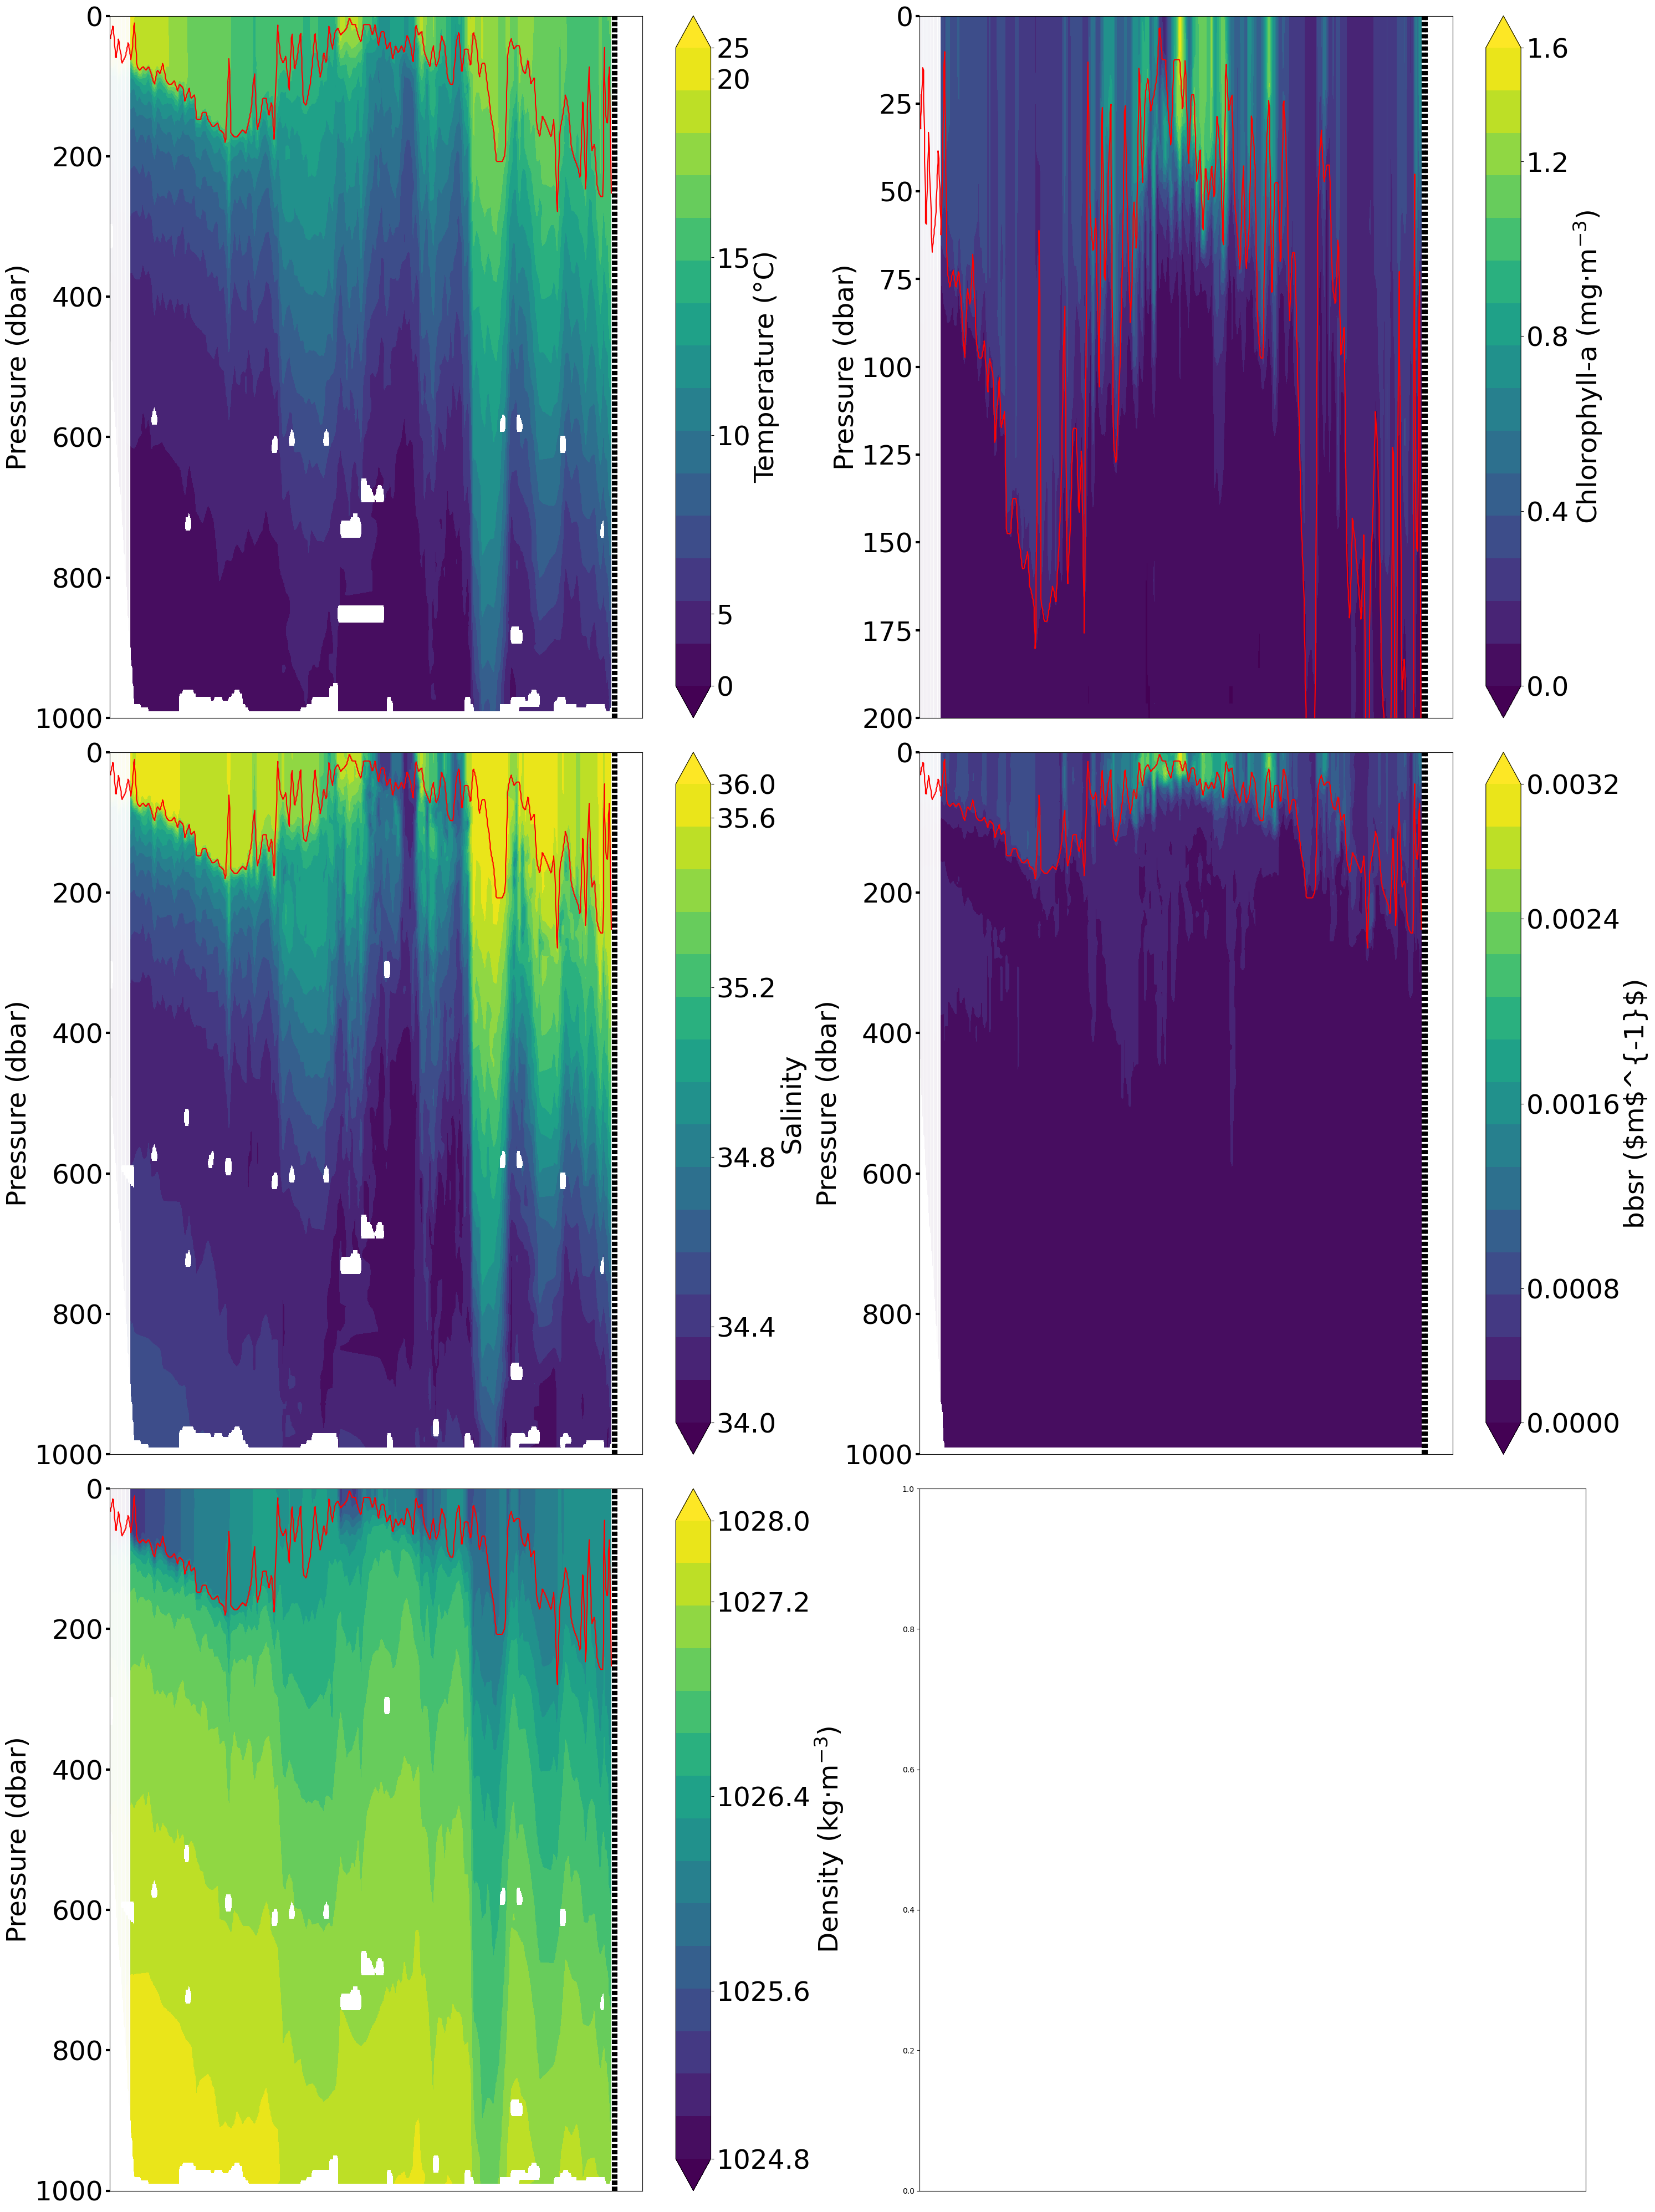

In [90]:
fig, axs = plt.subplots(3, 2, figsize=(30, 30), sharex=True)

create_contour_plot(
    ax = axs[0,0],
    df=ctd, 
    variable='TEMP',
    level = 15,
    log_transf=False, 
    divergent_color=False, 
    cb_label="Temperature (°C)", 
    display_features=True, 
    show_xticks=False, 
    show_yticks=True
)

create_contour_plot(
    ax = axs[1, 0],
    df=ctd, 
    variable='PSAL',
    level = 15,
    log_transf=False, 
    divergent_color=False, 
    cb_label="Salinity", 
    display_features=True, 
    show_xticks=False,
    show_yticks=True
)

create_contour_plot(
    ax = axs[2, 0],
    df=ctd, 
    variable='dens',
    level = 15,
    log_transf=False, 
    divergent_color=False, 
    cb_label="Density (kg$\cdot$m$^{-3}$)", 
    display_features=True, 
    show_xticks=True,
    show_yticks=True
)

create_contour_plot(
    ax = axs[0, 1],
    df=ctd, 
    variable='CHLA_ADJUSTED',
    level = 15,
    log_transf=False, 
    divergent_color=False, 
    cb_label="Chlorophyll-a (mg$\cdot$m$^{-3}$)", 
    display_features=True, 
    show_xticks=False,
    show_yticks=True
)

create_contour_plot(
    ax = axs[1, 1],
    df=bbsr, 
    variable='bbsr',
    level = 15,
    log_transf=True, 
    divergent_color=False, 
    cb_label="bbsr ($m$^{-1}$)", 
    display_features=True, 
    show_xticks=False,
    show_yticks=True
)

# Show the figure
plt.tight_layout()

#fig.savefig(f'/home/aaccardo/Accardo_et_al/Figures/contour_plots/MaP_MiP_abun.png', dpi = 300)
plt.show()

/tmp/ipykernel_3971192/3403257486.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks])


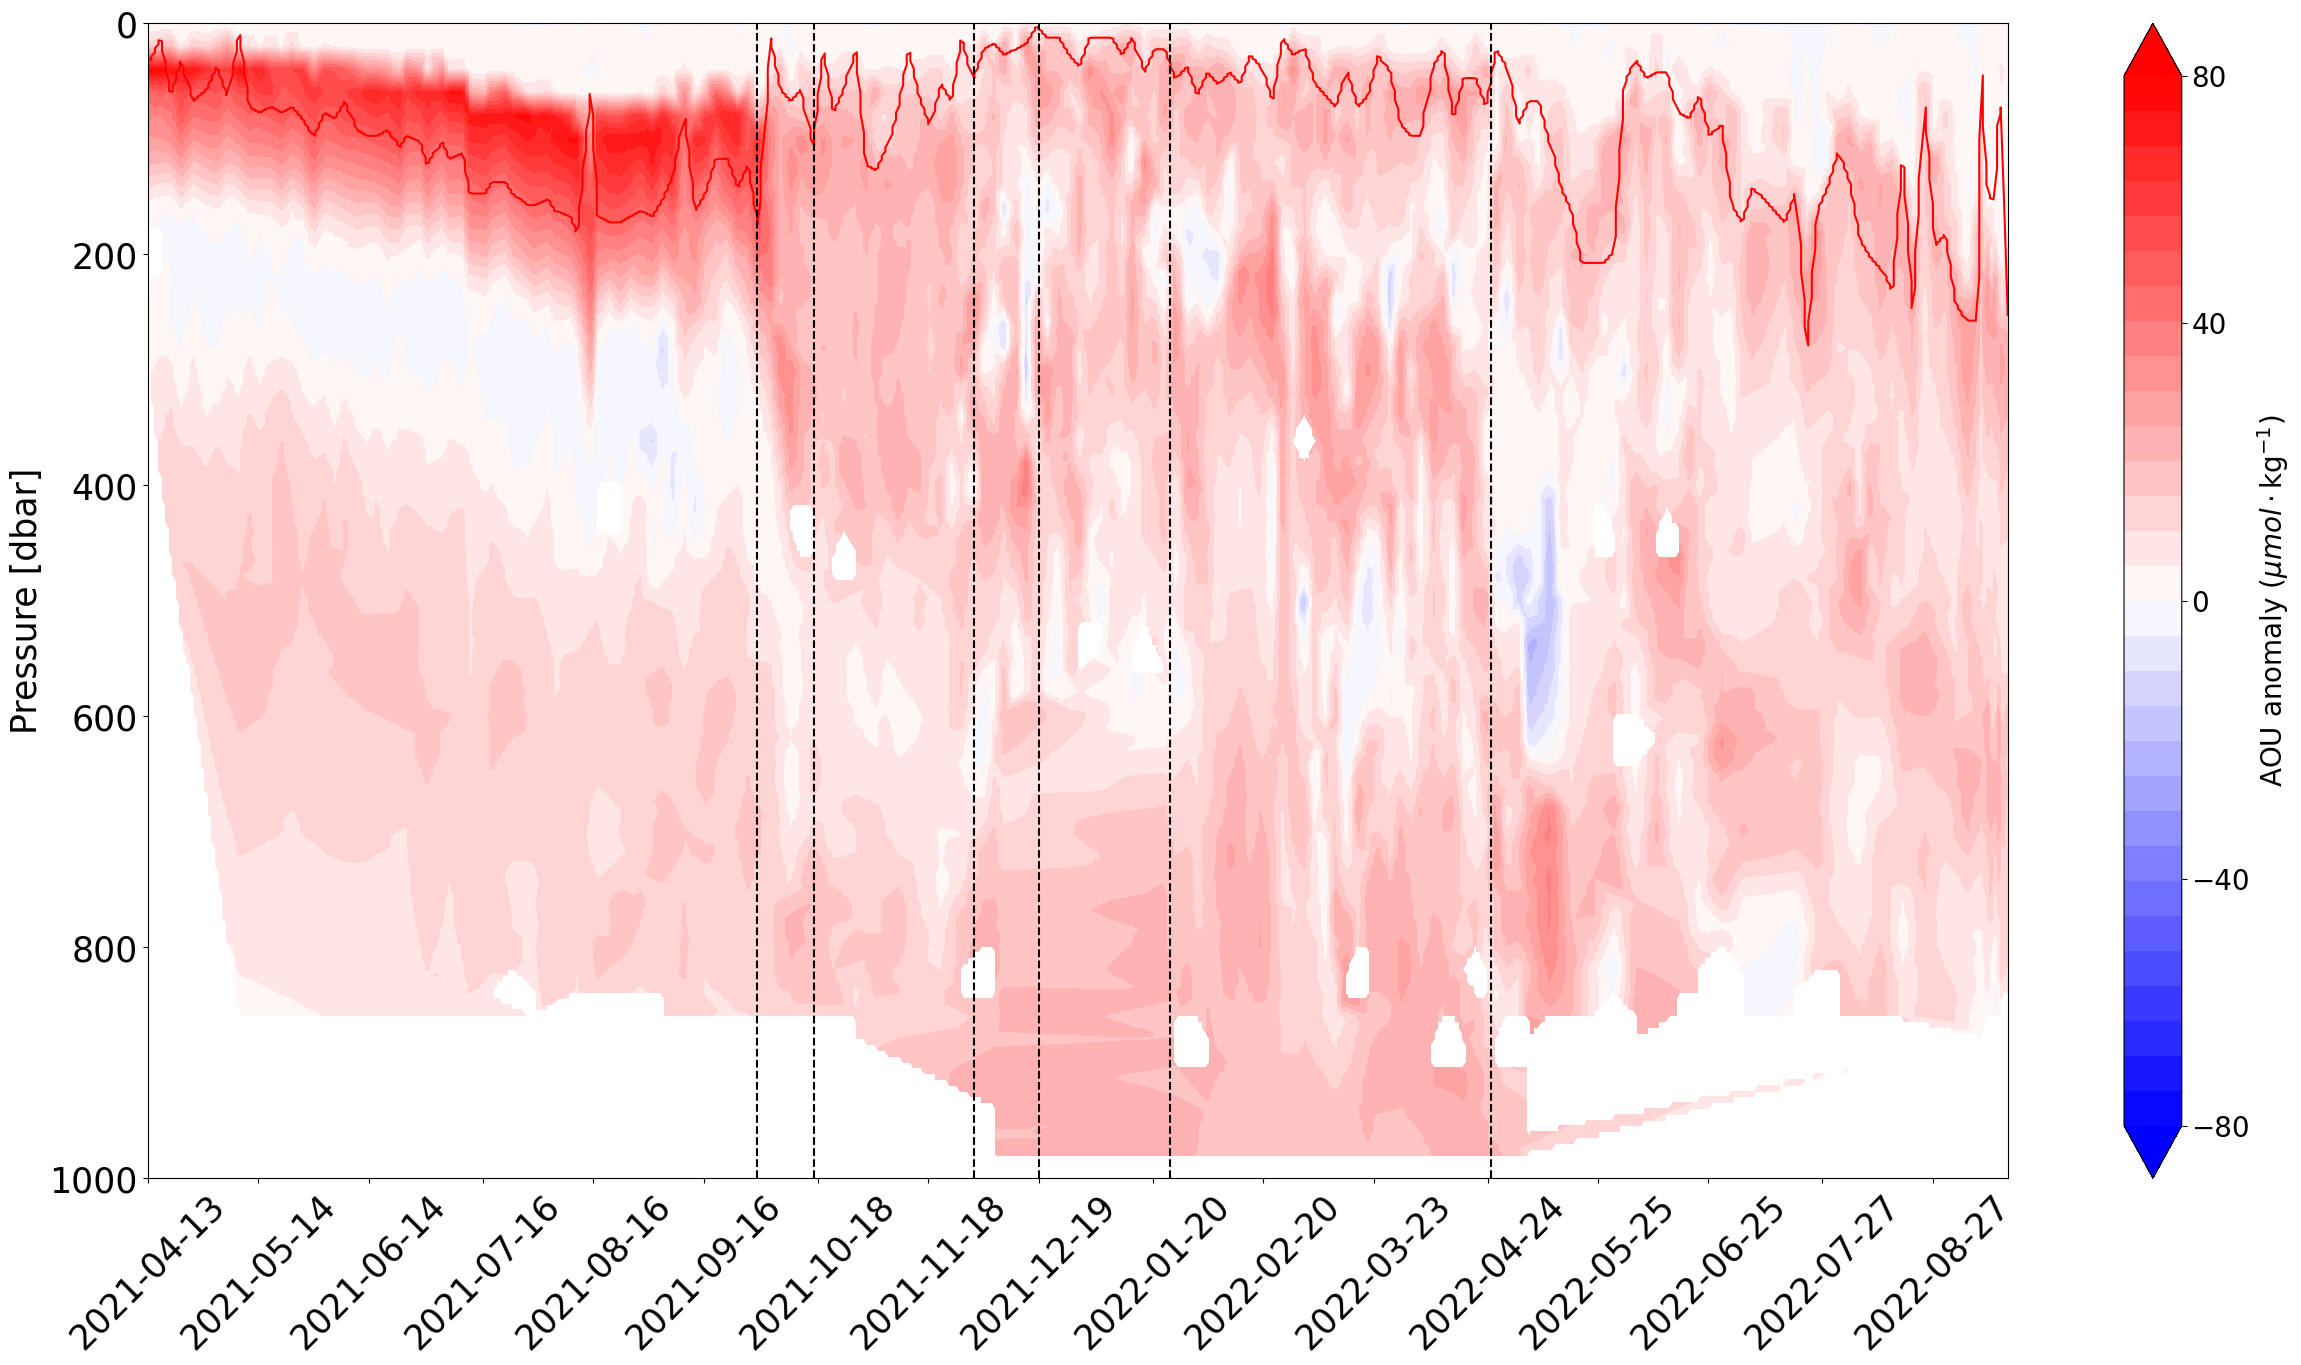

In [105]:
create_contour_plot(
    df=AOU, 
    variable='AOU µmol/kg_diff',
    save_path= '/home/aaccardo/Accardo_et_al/Figures/contour_plots/AOU_ano.pdf',
    log_transf=False, 
    divergent_color=True, 
    cb_label='AOU anomaly ($µmol\cdot$kg$^{-1}$)', 
    display_features=True, 
    show_xticks=True
)

In [101]:
# Import different dataset with the data 
ctd = pd.read_csv('/home/aaccardo/Accardo_et_al/Data/ctd_ano.csv')
ctd = ctd.drop('Profile', axis=1)
ctd = pd.merge(ctd, profile_date, on='CYCLE_NUMBER')
ctd['Date_Time'] = pd.to_datetime(ctd['Date_Time']).dt.strftime('%Y-%m-%d %H:%M:%S')

mld = pd.read_csv("/home/aaccardo/Accardo_et_al/Data/station_clines.csv")

ctd = ctd.dropna(subset=['Pressure [dbar]'])
ctd['Pressure [dbar]'] = ctd["Pressure [dbar]"].apply(lambda x: rounditup(x, 10, "floor"))
ctd = ctd.groupby(['CYCLE_NUMBER', 'Pressure [dbar]', 'Date_Time']).mean(numeric_only=True).reset_index()
ctd = pd.merge(ctd, mld, on = 'CYCLE_NUMBER')
ctd = ctd.rename(columns={'Date_Time': 'date', 'Longitude' : 'lon', 'Latitude':'lat', 'Pressure [dbar]':'Depth [m]'})
ctd['date'] = pd.to_datetime(ctd['date'])
ctd

,CYCLE_NUMBER,Depth [m],date,TEMP,POT_TEMP,ABS_SAL,PSAL,CHLA_ADJUSTED,DOXY_ADJUSTED,BBP700,dens,spiciness,TEMP_roll,POT_TEMP_roll,ABS_SAL_roll,PSAL_roll,CHLA_ADJUSTED_roll,DOXY_ADJUSTED_roll,BBP700_roll,dens_roll,spiciness_roll,TEMP_diff,POT_TEMP_diff,ABS_SAL_diff,PSAL_diff,CHLA_ADJUSTED_diff,DOXY_ADJUSTED_diff,BBP700_diff,dens_diff,spiciness_diff,lon,lat,thermocline,pycnocline,strat_index,DCM,MLD,temp_mld,chla_dcm_stock
0,1,0,2021-04-13 14:01:29,20.801865,20.800910,35.652127,35.484572,0.189800,230.495584,0.000710,1024.925276,3.906272,20.868890,20.868308,35.650218,35.482673,0.189800,230.369467,0.000691,1024.905536,3.923113,-0.067026,-0.067399,0.001909,0.001899,0.000000,0.126117,0.000019,0.019740,-0.016841,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
1,1,10,2021-04-13 14:01:29,20.704487,20.700209,35.706264,35.538433,0.147762,229.648861,0.000845,1024.993643,3.920025,20.756145,20.754007,35.670042,35.502396,0.175273,230.278048,0.000761,1024.951582,3.907143,-0.051658,-0.053798,0.036223,0.036038,-0.027510,-0.629187,0.000085,0.042061,0.012882,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
2,1,20,2021-04-13 14:01:29,20.727656,20.719585,35.751559,35.583476,0.241109,225.730892,0.001004,1025.022729,3.959603,20.743243,20.739206,35.700167,35.532363,0.179727,229.143697,0.000843,1024.978441,3.925967,-0.015587,-0.019621,0.051392,0.051113,0.061382,-3.412805,0.000161,0.044287,0.033637,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
3,1,30,2021-04-13 14:01:29,20.493727,20.481853,35.725826,35.557837,0.228844,214.973506,0.000792,1025.067036,3.876215,20.710386,20.704445,35.712494,35.544615,0.203849,226.583795,0.000857,1024.997161,3.925935,-0.216658,-0.222591,0.013332,0.013221,0.024995,-11.610289,-0.000066,0.069874,-0.049720,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
4,1,40,2021-04-13 14:01:29,15.742068,15.729228,35.246847,35.081086,0.161522,168.830209,0.000558,1025.866620,2.344668,20.092071,20.084558,35.656455,35.488826,0.198061,217.528072,0.000810,1025.109612,3.727732,-4.350003,-4.355330,-0.409608,-0.407740,-0.036539,-48.697863,-0.000252,0.757008,-1.383064,13.894444,-33.070000,82.5,82.5,2.076158,52.5,2.5,20.94088,5.624763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14617,184,890,2022-09-17 19:52:17,5.970136,5.883413,34.521994,34.357236,0.003650,221.070720,0.000263,1027.066879,0.019828,6.932724,6.845431,34.601369,34.436540,0.000943,218.086299,0.000281,1027.001457,0.209632,-0.962588,-0.962018,-0.079375,-0.079304,0.002738,2.957488,-0.000019,0.065422,-0.189805,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650
14618,184,900,2022-09-17 19:52:17,5.872999,5.786329,34.512595,34.347847,0.000000,222.505540,0.000275,1027.071588,0.000373,6.772428,6.685163,34.587380,34.422566,0.000730,218.253359,0.000280,1027.012345,0.176834,-0.899429,-0.898834,-0.074785,-0.074719,-0.000730,4.252181,-0.000005,0.059243,-0.176461,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650
14619,184,910,2022-09-17 19:52:17,5.783827,5.697107,34.504164,34.339419,0.000000,223.098700,0.000263,1027.075966,-0.017239,6.627942,6.540689,34.574868,34.410065,0.000782,218.469454,0.000281,1027.021889,0.147683,-0.844116,-0.843582,-0.070704,-0.070646,-0.000782,4.425157,-0.000018,0.054078,-0.164922,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650
14620,184,920,2022-09-17 19:52:17,5.674148,5.587388,34.495328,34.330577,0.000000,224.622850,0.000299,1027.082430,-0.037572,6.482481,6.395307,34.562207,34.397418,0.000782,219.234134,0.000283,1027.031303,0.118431,-0.808333,-0.807920,-0.066880,-0.066841,-0.000782,5.388716,0.000016,0.051127,-0.156003,10.214722,-34.425833,827.5,462.5,0.024390,2.5,252.5,16.04741,12.340650


/tmp/ipykernel_3971192/334987462.py:141: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks])


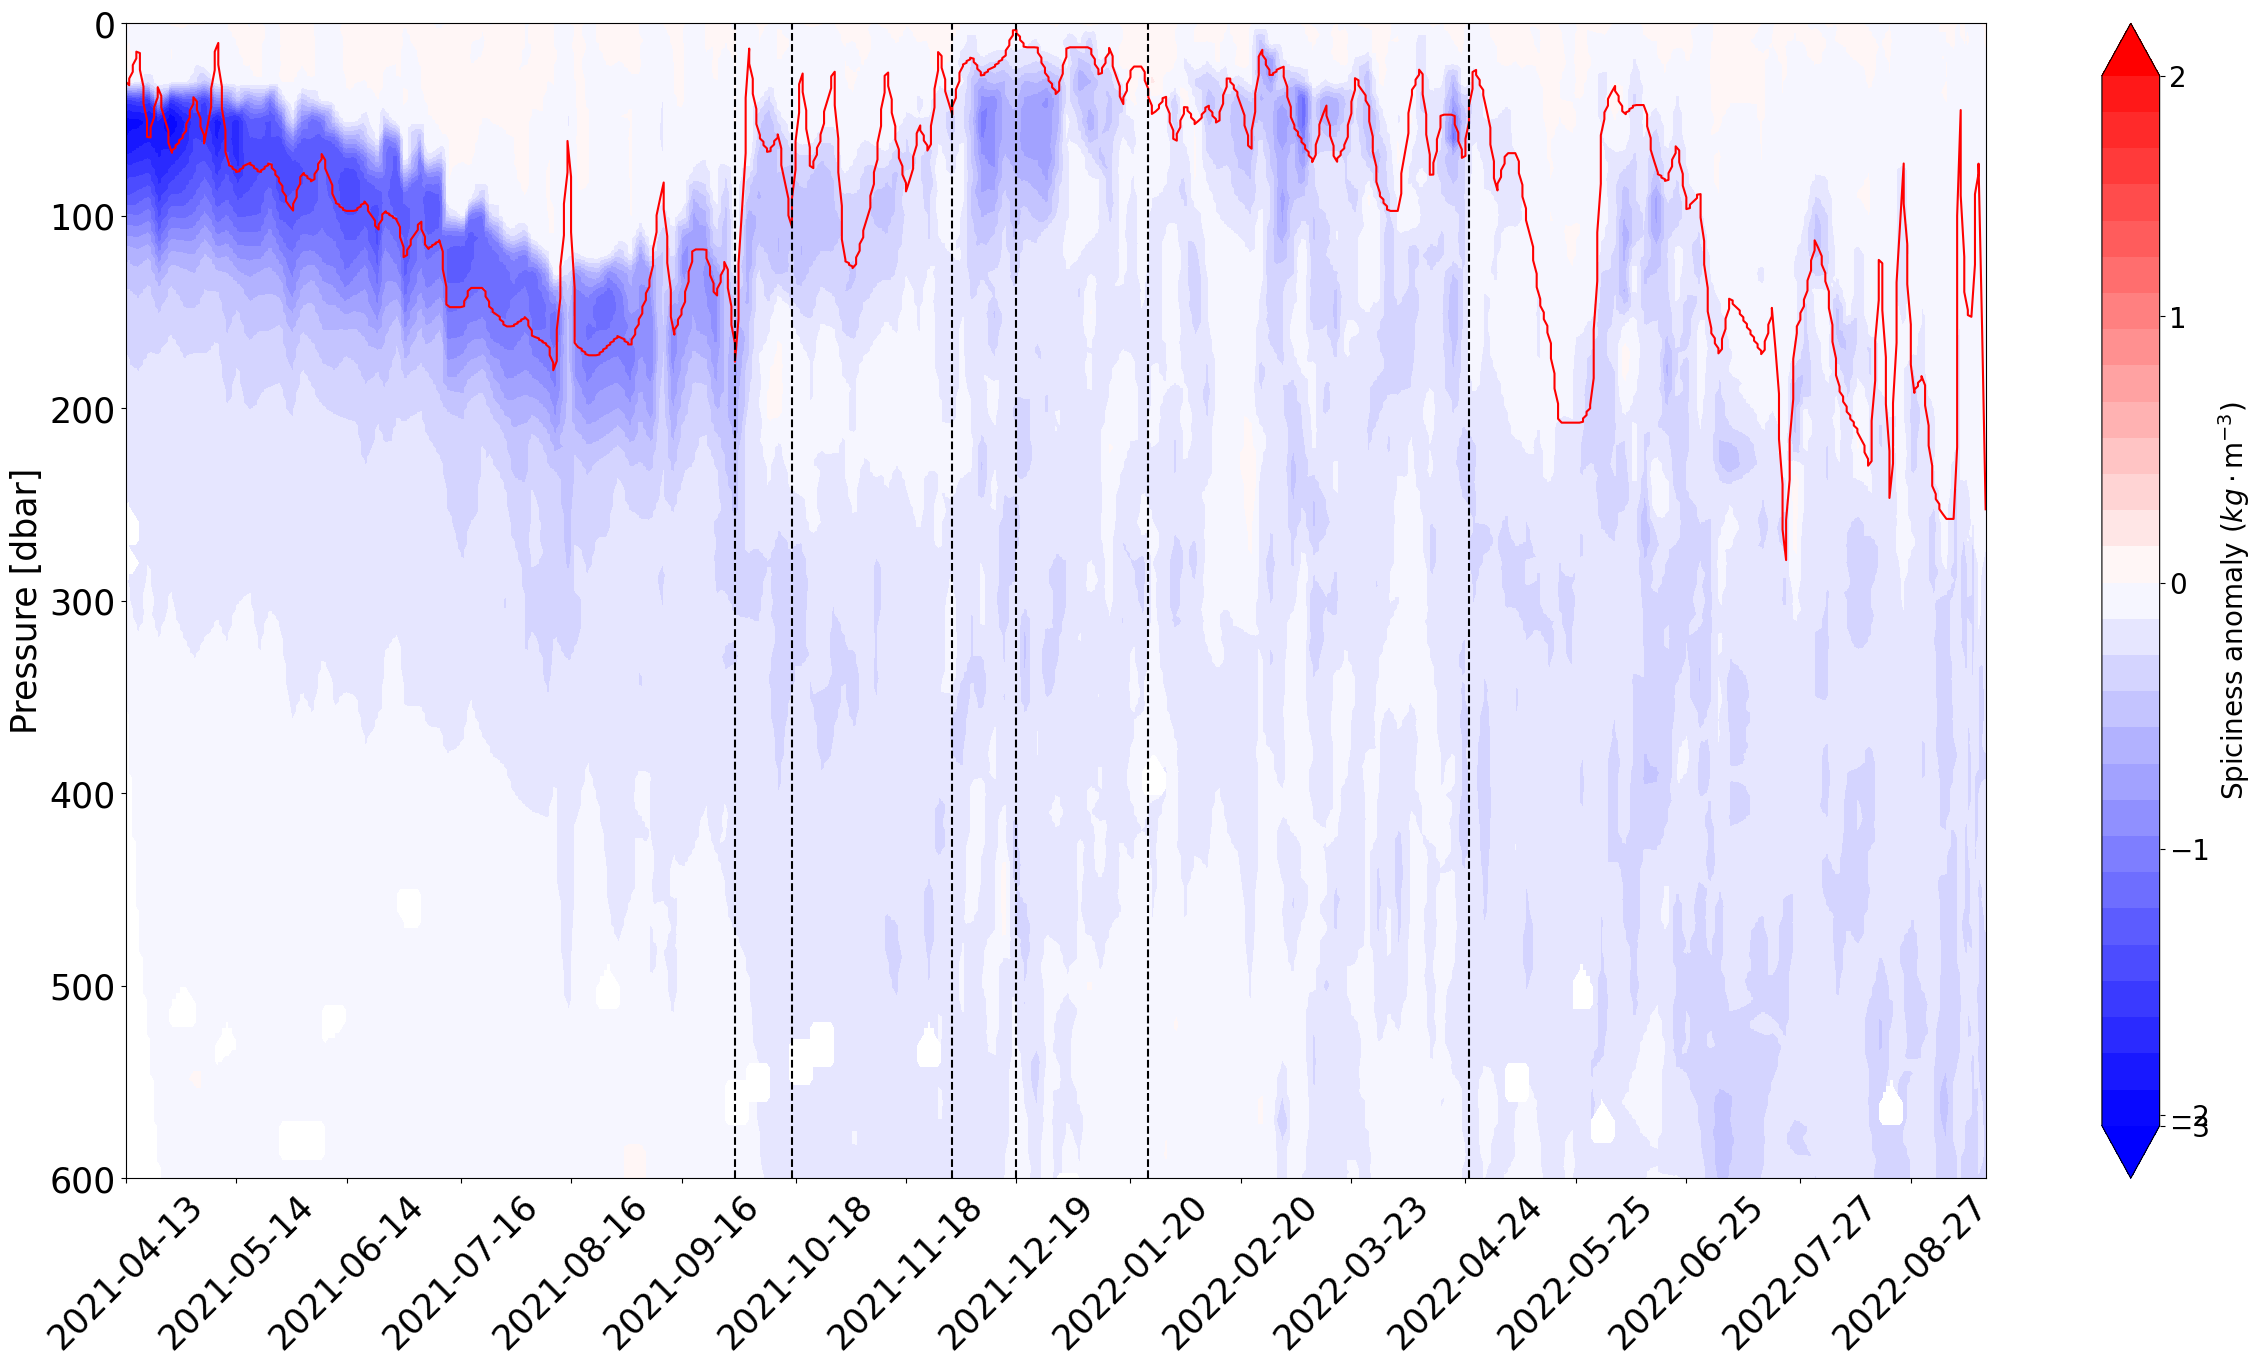

In [102]:
create_contour_plot(
    df=ctd, 
    variable='spiciness_diff', 
    save_path = '/home/aaccardo/Accardo_et_al/Figures/contour_plots/spiciness_ano.pdf',
    log_transf=False, 
    divergent_color=True, 
    cb_label='Spiciness anomaly ($kg\cdot$m$^{-3}$)', 
    display_features=True, 
    show_xticks=True
)

In [165]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.animation import FuncAnimation
import math

import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
from matplotlib import cm
from matplotlib.colors import Normalize

from datetime import timedelta
from matplotlib.ticker import FuncFormatter
from matplotlib import ticker
from matplotlib import colors

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
'''
def contour_levels_func(min_contour_level, max_contour_level, levels, variable):
    """Function to define contour levels for contourf"""
    import numpy as np
    
    if variable == 'PSAL' or 'density':
        distance_levels = abs(max_contour_level / levels)/100
    else:
        distance_levels = abs(max_contour_level / levels)#/100 # just for salinity and /100density data
    contour_levels = np.arange(min_contour_level, max_contour_level, distance_levels)
    return contour_levels
'''
def contour_levels_func(min_contour_level, max_contour_level, levels, variable):
    """Function to define contour levels for contourf"""
    import numpy as np
    
    # Adjust the conditional check
    if variable == 'PSAL' or variable == 'density':
        distance_levels = abs(max_contour_level - min_contour_level) / levels / 100
    else:
        distance_levels = abs(max_contour_level - min_contour_level) / levels  # For other variables

    # Generate contour levels using linspace for guaranteed levels
    contour_levels = np.linspace(min_contour_level, max_contour_level, levels + 1)  # +1 to include max level
    return contour_levels

def gridding_func(pos_min_max, depth_min_max, pos_array, depth, param):
    import numpy as np
    from scipy.interpolate import griddata
    grid_method = "linear"  # choose the gridding method here
    # method to do the regridding, can be nearest (for nearest neighbour) or linear
    xi_linear = np.linspace(min(pos_min_max), max(pos_min_max), 50)
    xi_original = np.unique(pos_array)
    xi = np.unique(np.sort(np.concatenate((xi_linear, xi_original))))
    
    yi_linear = np.linspace(min(depth_min_max), max(depth_min_max), 100) # If depth max = 2000m, with 20m bins --> 100 sampled depths --> 200 with interpolation
    yi_original = np.unique(depth)
    yi = np.unique(np.sort(np.concatenate((yi_linear, yi_original))))    
    
    zi = griddata((pos_array, depth), param, (xi[None, :], yi[:, None]), method=grid_method)
    return xi, yi, zi

def nonlinear_colormap():
    import pylab as pyl
    #import numpy as np
    levels1 = [0, 1, 2]
    
# Set up a function to format the y-axis tick labels without the minus sign
def format_y_ticks(value, pos):
    return abs(int(value))
    
def create_contour_plot(ax, data, variable, levels, log_transf=True, divergent_color=False, cb_label="Concentration", display_features = False, show_xticks=True, ylabel = True):

    df = data.copy()
    df['date'] = pd.to_datetime(df['date'])
    ref_date = np.min(df['date'])
    df['days'] = (df['date'] - ref_date).dt.days

    time_array = np.unique(np.array(df['days']))

    # Keep only 0-600m
    df = df[df['Depth [m]'] <= 1000]

    # For log transformation
    if log_transf:
        df[f'{variable}_log'] = df[variable].apply(lambda x: np.log1p(x))

    # Prepare data for contour plotting
    df.days = df.days.astype(float)
    dat = np.array(df['days'])
    real_date = np.unique([ref_date + timedelta(days=j) for j in dat])
    real_formatted_dates = [k.strftime("%d/%m/%y") for k in real_date]
    depth = np.array(df['Depth [m]'] * (-1))

    # Prepare for contour levels
    if log_transf:
        parameter_dict = {f'{variable}': [min(df[f'{variable}_log']), max(df[f'{variable}_log'])]}
    else:
        parameter_dict = {f'{variable}': [min(df[variable]), max(df[variable])]}

    legend_dict = {f'{variable}': cb_label}

    # Generate contour plots for each parameter
    for p in parameter_dict.keys():
        param = np.array(df[p])

        # Set limits for depth and time
        depth_min_max = [0, -1000]
        pos_min_max = [min(df.days), max(df.days)]

        # Interpolate
        xi, yi, zi = gridding_func(pos_min_max, depth_min_max, dat, depth, param)

        # Set contour levels
        levels = levels
        min_contour_level = parameter_dict[p][0]
        max_contour_level = parameter_dict[p][1]       
        contour_levels = contour_levels_func(min_contour_level, max_contour_level, levels, variable = variable)
        #print(f'contour_levels for {variable}: ', contour_levels)
        
        # color bar 
        cmap = 'viridis'
        
        # Interpolate MLD
        mld_raw = df[['days', 'MLD']]
        mld_raw.days = mld_raw.days.astype(float)
        mld_interp = np.interp(xi, mld_raw.days, mld_raw.MLD)
        
        # Convert days back to dates for plotting
        date_list = [ref_date + timedelta(days=i) for i in xi]
        formatted_dates = [d.strftime("%d/%m/%y") for d in date_list]

        # Plot contour
        if log_transf:
            p1 = ax.contourf(formatted_dates, yi, np.log1p(zi), contour_levels, cmap=cmap, alpha=1, extend="both")
        else:
            p1 = ax.contourf(formatted_dates, yi, zi, contour_levels, cmap=cmap, alpha=1, extend="both")

        # Plot real data (used for interpolation)  
        '''
        for date in real_formatted_dates:  
            ax.axvline(date, color='white', linestyle='-', linewidth=1.5, alpha = 0.3) # Real profiles 
            dataframe = df[df['date'] == date]
            dataframe = dataframe[['Depth [m]', 'date']]
            dataframe['date'] = dataframe['date'].dt.strftime("%d/%m/%y")
            #print(dataframe)
            ax.scatter(dataframe['date'], dataframe['Depth [m]']* (-1), color = 'white', s = 1, alpha = 0.3) # Real sampled depths
        '''
        # mld
        ax.plot(formatted_dates, -mld_interp, color='red')            
        '''
        if display_features:
            # Represent features with dashed lines
            feature_dates = ["2021-10-01", "2021-10-17", "2021-12-01", 
                             "2021-12-19", "2022-01-25", "2022-04-25"]
            
            # Convert to desired date format
            feature_dates = [datetime.strptime(date, "%Y-%m-%d").strftime("%d/%m/%y") for date in feature_dates]
            
            for date in feature_dates:
                ax.axvline(x=date, color='black', linestyle='dashed')      
      
        '''
        # Plotting parameters for contour
        if ylabel:
            ax.set_ylabel("Pressure (dbar)", fontsize=30)
        else:
            ax.set_ylabel("")
            
        if variable == 'CHLA_ADJUSTED':
            ax.set_ylim(-300, 0)
        else:
            ax.set_ylim(-1000, 0)
        
        ax.tick_params(axis='y', labelsize=35)

        # Set y-ticks to absolute values
        y_ticks = ax.get_yticks()
        ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize=35)

        # Set x-axis tick frequency
        if show_xticks:
            ax.set_xticks(formatted_dates[::30])  # Show ticks
            ax.set_xticklabels(formatted_dates[::30], rotation=45, fontsize=35)
        else:
            ax.set_xticks([])

        # Colorbar for the contour plot
        cb = plt.colorbar(p1, ax=ax, orientation='vertical')
        if variable == 'bbsr':
            cb.ax.set_ylabel(f"{legend_dict[p]} (×10$^{{3}}$)", fontsize=30)
            cb.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x * 1e3:.1f}'))
            cb.ax.tick_params(labelsize=25)
        else:
            cb.ax.set_ylabel(legend_dict[p], fontsize=30)
            cb.ax.tick_params(labelsize=25)

    
        tick_locator = ticker.MaxNLocator(nbins=5)
        cb.locator = tick_locator



/tmp/ipykernel_428830/2660524878.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize=35)
/tmp/ipykernel_428830/2660524878.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize=35)
/tmp/ipykernel_428830/2660524878.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize=35)
/tmp/ipykernel_428830/2660524878.py:182: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([abs(int(y)) for y in y_ticks], fontsize=35)
/tmp/ipykernel_428830/2660524878.py:182: UserWarning: set_ti

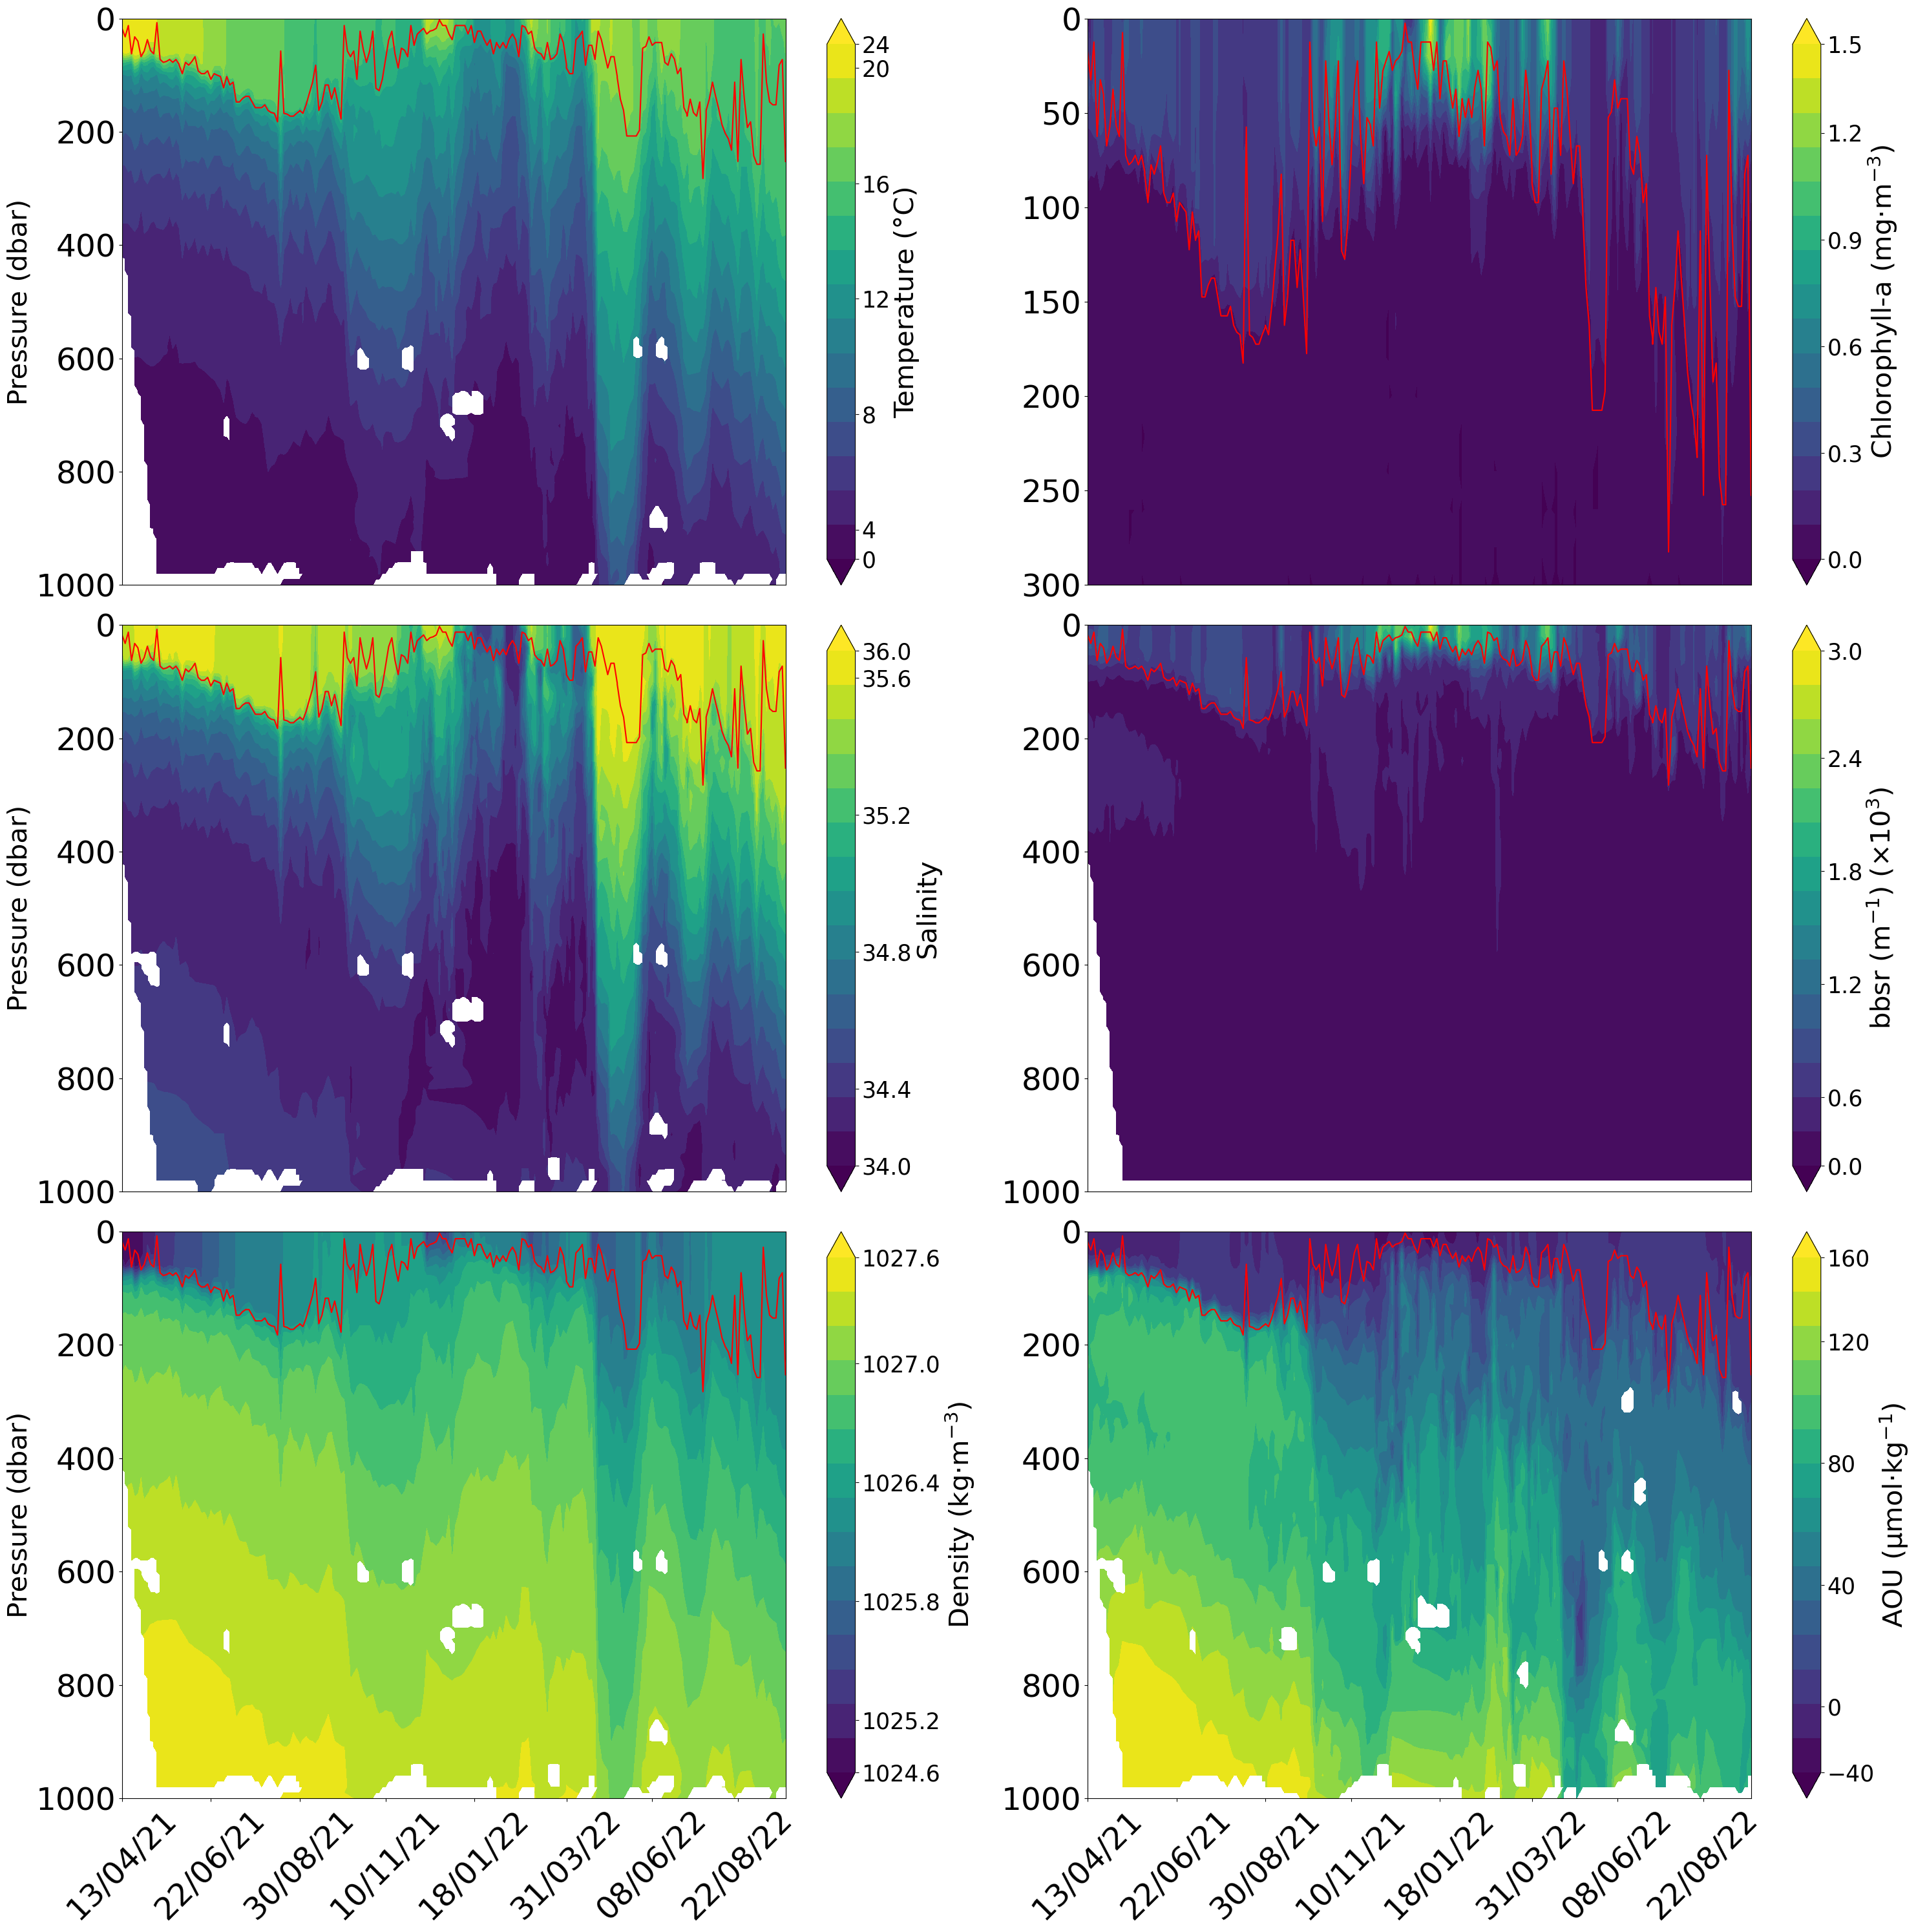

In [166]:
fig, axs = plt.subplots(3, 2, figsize=(30, 30))

levels = 15
create_contour_plot(ax=axs[0, 0], data=ctd, variable="TEMP", levels = levels, log_transf=False, display_features= False, cb_label="Temperature (°C)", show_xticks=False, ylabel = True)
create_contour_plot(ax=axs[1, 0], data=ctd, variable="PSAL", levels = levels, log_transf=False, cb_label="Salinity", show_xticks=False, ylabel = True)
create_contour_plot(ax=axs[2, 0], data=ctd, variable="dens", levels = levels, log_transf=False, cb_label="Density (kg$\cdot$m$^{-3}$)", show_xticks=True, ylabel = True)
create_contour_plot(ax=axs[0, 1], data=ctd, variable="CHLA_ADJUSTED", levels = levels, log_transf=False, cb_label="Chlorophyll-a (mg$\cdot$m$^{-3}$)", show_xticks=False, ylabel = False)
create_contour_plot(ax=axs[1, 1], data=bbsr, variable="bbsr", levels = levels, log_transf=True, cb_label="bbsr (m$^{-1}$)", show_xticks=False, ylabel = False)
create_contour_plot(ax=axs[2, 1], data=AOU, variable="AOU µmol/kg", levels = levels, log_transf=False, cb_label="AOU (µmol$\cdot$kg$^{-1}$)", show_xticks=True, ylabel = False)

# Show the figure
plt.tight_layout()
#fig.savefig(f'/home/aaccardo/Accardo_et_al/Figures/contour_plots/figure_2.png', dpi = 300)
plt.show()